In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np 
import random

In [ ]:
data_dir = "/content/drive/MyDrive/AIproj/data/"
model_dir = Path("/content/drive/MyDrive/AIproj/models/")

In [ ]:
import sys
sys.path.insert(0,'/content/drive/My Drive/AIproj/')
import importlib
# importlib.reload(my_lib)
import my_lib

### Read data and preprocess

In [ ]:
dl = my_lib.DataLoader(data_dir)

In [ ]:
# data = dl.preprocess_data(weeks=5)

In [ ]:
data = dl.load_data('encoded_full5') # 5 weeks only 

In [ ]:
user_columns = ['customer_id', 'FN', 'Active', 'age',
       'fashion_news_frequency_0', 'fashion_news_frequency_Monthly',
       'fashion_news_frequency_NONE', 'fashion_news_frequency_None',
       'fashion_news_frequency_Regularly', 'club_member_status_0',
       'club_member_status_ACTIVE', 'club_member_status_LEFT CLUB',
       'club_member_status_PRE-CREATE']

item_columns = ['article_id', 'index_group_name_copy',
       'index_group_name_Baby/Children', 'index_group_name_Divided',
       'index_group_name_Ladieswear', 'index_group_name_Menswear',
       'index_group_name_Sport']

In [ ]:
data['user'] = data['user'][user_columns]
data['item'] = data['item'][item_columns]

#### Train/text/validation split

In [ ]:
val_end_date = data['inter']['t_dat'].max()
train_end_date = val_end_date - pd.Timedelta(days=7)


In [ ]:

train, valid, valid_full = dl.split_data(data['inter'], train_end_date, val_end_date)

In [ ]:
n=15 

train = train.merge(data['item'][['article_id','index_group_name_copy']])
user_info = train.groupby(['customer_id'])['index_group_name_copy'].agg(pd.Series.mode).reset_index()
user_info['mean_price'] = train.groupby(['customer_id'])['price'].mean().reset_index(name='mean_price')['mean_price']
user_info['price_cat'] = pd.qcut(user_info['mean_price'],5,labels=False)
del user_info['mean_price']
user_info["index_group_name_copy"] = user_info["index_group_name_copy"].astype(str)


In [ ]:
data['user'] = data['user'].merge(user_info)
customers_train = np.unique(np.concatenate((train['customer_id'].unique(), valid['customer_id'].unique()), axis=0))
bin_values = [0, 18, 20, 24, 28, 32, 36, 40, 45, 50, 60, 100]
data['user']['age_group'] = pd.cut(data['user']['age'], bin_values)

In [ ]:
train = train.merge(data['user'][['customer_id','age_group', 'price_cat', 'index_group_name_copy']])

In [ ]:

res1 = my_lib.OrderHistory(train, days=7, name='7days').retrieve() 
res2 = my_lib.OrderHistory(train, days=28, name='28days').retrieve() 
res3 = my_lib.TimeHistory(customers_train,train, days=7, name='7days', n=n).retrieve() 
res4 = my_lib.TimeHistory(customers_train,train, days=28, name='28days', n=n).retrieve() 
res5 = my_lib.UserGroupTimeHistory(data, customers_train, train, ['age_group'], name='age_group', n=n).retrieve()
res6 = my_lib.UserGroupTimeHistory(data, customers_train, train, ['index_group_name_copy'], name='index_group_name_copy', n=n).retrieve()
res7 = my_lib.UserGroupTimeHistory(data, customers_train, train, ['price_cat'], name='price_group', n=n).retrieve()


/content/drive/My Drive/AIproj/my_lib.py:265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["count"] = 1


In [ ]:
res = res3.append(res4).groupby(['customer_id', 'article_id'])['score'].sum().reset_index()
res = res.append(res1).groupby(['customer_id', 'article_id'])['score'].sum().reset_index()
res = res.append(res2).groupby(['customer_id', 'article_id'])['score'].sum().reset_index()
res = res.append(res5).groupby(['customer_id', 'article_id'])['score'].sum().reset_index()
res = res.append(res6).groupby(['customer_id', 'article_id'])['score'].sum().reset_index()
res = res.append(res7).groupby(['customer_id', 'article_id'])['score'].sum().reset_index()

In [ ]:
res['article_id'] = res['article_id'].astype(int)

In [ ]:
### candidates

### Candidate generation

In [ ]:

subm_trans = data['inter'][data['inter']['t_dat'] >= (val_end_date - pd.Timedelta(days=28))]

In [ ]:

subm_trans = subm_trans.merge(data['item'][['article_id','index_group_name_copy']])
user_info = subm_trans.groupby(['customer_id'])['index_group_name_copy'].agg(pd.Series.mode).reset_index()
user_info['mean_price'] = subm_trans.groupby(['customer_id'])['price'].mean().reset_index(name='mean_price')['mean_price']
user_info['price_cat'] = pd.qcut(user_info['mean_price'],5,labels=False)
del user_info['mean_price']
user_info["index_group_name_copy"] = user_info["index_group_name_copy"].astype(str)
data['user'] = data['user'].merge(user_info)

In [ ]:
bin_values = [0, 18, 20, 24, 28, 32, 36, 40, 45, 50, 60, 100]
data['user']['age_group'] = pd.cut(data['user']['age'], bin_values)


In [ ]:
n=15
customers = data['subm']['customer_id'].unique()


In [ ]:
subm_trans = subm_trans.merge(data['user'][['customer_id','age_group', 'price_cat', 'index_group_name_copy']])

In [ ]:

res1 = my_lib.OrderHistory(subm_trans, days=7, name='7days').retrieve() 
res2 = my_lib.OrderHistory(subm_trans, days=28, name='28days').retrieve() 
res3 = my_lib.TimeHistory(customers,subm_trans, days=7, name='7days', n=n).retrieve() 
res4 = my_lib.TimeHistory(customers,subm_trans, days=28, name='28days', n=n).retrieve() 
# res5 = my_lib.UserGroupTimeHistory(data, customers, subm_trans, ['age_group'], name='age_group', n=n).retrieve()
# res6 = my_lib.UserGroupTimeHistory(data, customers, subm_trans, ['index_group_name_copy'], name='index_group_name_copy', n=n).retrieve()
# res7 = my_lib.UserGroupTimeHistory(data, customers, subm_trans, ['price_cat'], name='price_group', n=n).retrieve()


In [ ]:
res_ = res3.append(res4).groupby(['customer_id', 'article_id'])['score'].sum().reset_index()
res_ = res_.append(res1).groupby(['customer_id', 'article_id'])['score'].sum().reset_index()
res_ = res_.append(res2).groupby(['customer_id', 'article_id'])['score'].sum().reset_index()
# res_ = res_.append(res5).groupby(['customer_id', 'article_id'])['score'].sum().reset_index()
# res_ = res_.append(res6).groupby(['customer_id', 'article_id'])['score'].sum().reset_index()
# res_ = res_.append(res7).groupby(['customer_id', 'article_id'])['score'].sum().reset_index()

In [ ]:
def select_n_candidates(res, n, name='score'): 
  res['rank'] = res.groupby('customer_id')[name].rank(ascending=False, method='first')
  res = res[res['rank'] <= n]
  res = (res.groupby(["customer_id"])['article_id'].apply(list).reset_index())
  return res

def write_submission(results, dl, name):
  sample_df = dl.read_submission_data()
  sample_df = sample_df.merge(results.rename({'customer_id':'customer_id_2'},axis=1),\
    on='customer_id_2', how='left').fillna('')
  del sample_df['customer_id_2']
  del sample_df['prediction']
  return dl.save_submission(sample_df, name)
  

In [ ]:
sub4 = select_n_candidates(res, 12, name='score') # top popular and order history (7 and 28 days)
_ = write_submission(sub4, dl, name='month_hist_pop')

In [ ]:
# res_pred = pd.merge(candidates, valid, on='customer_id', suffixes=('_pred', '_valid'))
# value = my_lib.mean_average_precision(res_pred['article_id_valid'], res_pred['article_id_pred'], k=12)
# print(round(value, 6))

# 28 days
# 0.011549 - OrderHistory (7) and TimeHistory (28) 
# 0.004793 - TimeHistory (28) only

# 0.011427 - OrderHistory (28) and TimeHistory (28)

# 7 days
# 0.005512 - TimeHistory (7) only 
# 0.005237 - TimeHistory (7 days and 28 days)

0.010836


### Feature creation 

In [ ]:
def price_predictors(transactions_processed, last_date, train=True):
  transactions_processed = transactions_processed[transactions_processed['t_dat'] <= last_date]
  # price of purchased items 
  if train:
    transactions_processed['ordered'] = transactions_processed['ordered'].astype(int)
    transactions_processed['price_calc'] = transactions_processed['price'] * transactions_processed['ordered']
    transactions_processed['price_calc'] = transactions_processed['price_calc'].astype(float)
  else: 
    transactions_processed['price_calc'] = transactions_processed['price'].astype(float)

  # sort transactions 
  transactions_processed.sort_values(["customer_id", "t_dat"],
                axis = 0, ascending = True,
                inplace = True,
                na_position = "first")
  
  # history of purchases 
  ## cummulative sum of purchases
  transactions_processed['price_csum'] = transactions_processed.groupby(['customer_id'])['price_calc'].cumsum() - transactions_processed['price_calc']
  ## number of purchases
  transactions_processed['purchase_cnt'] = transactions_processed.groupby(['customer_id'])['ordered'].cumsum() - transactions_processed['ordered']
  # transactions_processed['purchase_cnt_cat'] = transactions_processed.groupby(['customer_id', 'index_group_name'])['ordered'].cumsum() - transactions_processed['ordered']

  ## average price of purchases
  transactions_processed['price_mean'] = transactions_processed['price_csum'] / transactions_processed['purchase_cnt']
  transactions_processed['price_mean'] = transactions_processed['price_mean'].fillna(0)
  return transactions_processed

In [ ]:
import datetime
def purchases_predictors(transactions_processed, last_date):
    
  transactions_processed = transactions_processed[transactions_processed['t_dat'] <= last_date]
  last_purchases = transactions_processed.groupby(['customer_id', 't_dat'])['ordered'].sum().reset_index()

    # puchases in previous 7 / 30 / 90 days
  last_purchases['purchases_7'] = last_purchases.set_index('t_dat').groupby('customer_id').rolling('7D')['ordered'].sum().reset_index()['ordered'] - last_purchases['ordered']
  last_purchases['purchases_30'] = last_purchases.set_index('t_dat').groupby('customer_id').rolling('30D')['ordered'].sum().reset_index()['ordered'] - last_purchases['ordered']

  last_purchases['purchases_ratio'] = last_purchases['purchases_7'] / last_purchases['purchases_30']
  last_purchases['purchases_ratio'] = last_purchases['purchases_ratio'].fillna(0)

  # merge with all data
  transactions_processed = transactions_processed.merge(
      last_purchases[['customer_id', 't_dat', 'purchases_7', 'purchases_30', 'purchases_ratio']], 
      how='inner', on=['customer_id', 't_dat']
  )
  return transactions_processed

In [ ]:
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing

# negative sampling based on candidates

In [ ]:
article_features = ['index_group_name_copy','index_group_name_Baby/Children', 'index_group_name_Divided',
       'index_group_name_Ladieswear', 'index_group_name_Menswear',
       'index_group_name_Sport']

customer_features = ['FN', 'Active', 'age', 'club_member_status_0',
       'club_member_status_ACTIVE', 'club_member_status_LEFT CLUB',
       'club_member_status_PRE-CREATE', 'fashion_news_frequency_Monthly',
       'fashion_news_frequency_NONE', 'fashion_news_frequency_Regularly']

calc_features = ['price_csum', 'purchase_cnt',
       'price_mean', 'purchases_7', 'purchases_30', 'purchases_ratio']

In [ ]:
# train
train_candidates = res[res['customer_id'].isin(train.customer_id.unique())]
train_candidates['t_dat'] = train_end_date + pd.Timedelta(days=1)
train_candidates['price'] = 0
train['ordered'] = 1
train_candidates['ordered'] = 0
train_en = pd.concat([train, train_candidates])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [ ]:
train_en.ordered.mean()

0.07474100334719605

In [ ]:
train_en = train_en.merge(data['user'][customer_features + ['customer_id']], on='customer_id')
train_en = train_en.merge(data['item'][article_features + ['article_id']], on='article_id')

train_en = price_predictors(train_en, val_end_date)
train_en = purchases_predictors(train_en, val_end_date)


In [ ]:
train_en.ordered.mean() 

0.07474100334719605

In [ ]:
# valid
valid_candidates = res[res['customer_id'].isin(valid_full.customer_id.unique())]
valid_candidates['t_dat'] = train_end_date + pd.Timedelta(days=1)
valid_candidates['price'] = 0
train['ordered'] = 1
valid_full['ordered'] = 1
valid_en = pd.concat([valid_full, valid_candidates])
valid_en['ordered'].fillna(0, inplace=True)
valid_en['valid'] = 1

valid_en = pd.concat([valid_en, train])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [ ]:
valid_en = valid_en.merge(data['user'][customer_features + ['customer_id']], on='customer_id')
valid_en = valid_en.merge(data['item'][article_features + ['article_id']], on='article_id')

valid_en = price_predictors(valid_en, data['inter']['t_dat'].max())
valid_en = purchases_predictors(valid_en, data['inter']['t_dat'].max())


In [ ]:
valid_en = valid_en[valid_en['valid'] == 1]

In [ ]:
valid_en.ordered.mean()

0.07057129512312818

In [ ]:
features = ['FN', 'Active', 'age', 'price_csum',
       'purchase_cnt', 'price_mean',
       'purchases_7', 'purchases_30', 'purchases_ratio', 
       'index_group_name_Baby/Children', 'index_group_name_Divided',
       'index_group_name_Ladieswear', 'index_group_name_Menswear',
       'index_group_name_Sport', 'club_member_status_0',
       'club_member_status_ACTIVE', 'club_member_status_LEFT CLUB',
       'club_member_status_PRE-CREATE', 'fashion_news_frequency_Monthly',
       'fashion_news_frequency_NONE', 'fashion_news_frequency_Regularly']

In [ ]:
import lightgbm as lgb

In [ ]:
def train_binary_model(train, valid, feats, target='ordered'):
    params = {
      "objective": "binary", #"lambdarank",
      "boosting_type": "gbdt",
      "metric": "auc", #"map",
      "max_depth":8,
      "num_leaves": 128,
      "learning_rate": 0.03,

      "verbose": -1,
      "eval_at": 12,
      # 'device':'gpu'
    } 
    train_set = lgb.Dataset(
        data=train[feats],
        label=train[target],
        feature_name=feats,
        params=params,
    )

    valid_set = lgb.Dataset(
        data=valid[feats],
        label=valid[target],
        feature_name=feats,
        params=params,
    )

    ranker = lgb.train(
        params,
        train_set,
        num_boost_round=200,
        valid_sets=[valid_set],
        early_stopping_rounds=30,
        verbose_eval=10,
    )
    ranker.save_model(
        "/content/drive/MyDrive/AIproj/models/lgb_large_ranker.model",
        num_iteration=ranker.best_iteration,
    )
    return ranker

In [ ]:
import gc
gc.collect()

88

In [ ]:
ranker = train_binary_model(train_en, valid_en, features)

Training until validation scores don't improve for 30 rounds.
[10]	valid_0's auc: 0.808026
[20]	valid_0's auc: 0.811416
[30]	valid_0's auc: 0.812425
[40]	valid_0's auc: 0.811703
Early stopping, best iteration is:
[18]	valid_0's auc: 0.813215


In [ ]:
ranker.save_model(
    "/content/drive/MyDrive/AIproj/models/lgb_large_ranker.model",
    num_iteration=ranker.best_iteration,
)

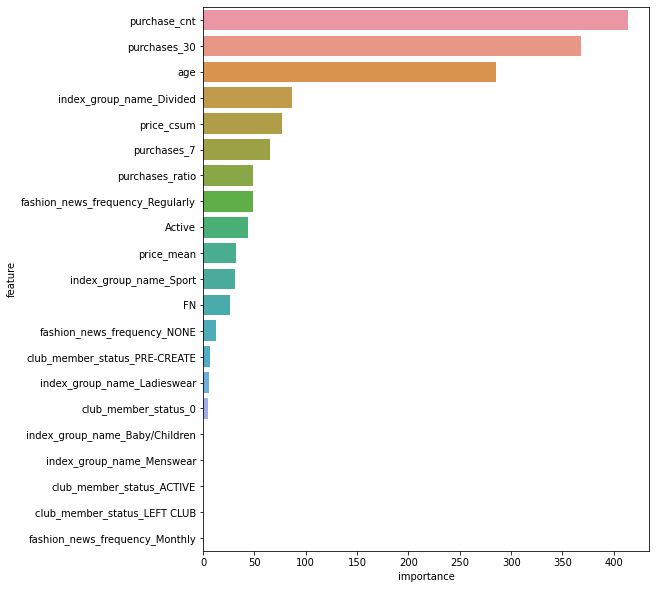

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

feat_importance = pd.DataFrame(
    {"feature": features, "importance": ranker.feature_importance()}
).sort_values(by="importance", ascending=False)
plt.figure(figsize=(8, 10))
sns.barplot(y="feature", x="importance", data=feat_importance)

In [ ]:
ranker.params

{'objective': 'binary',
 'boosting_type': 'gbdt',
 'metric': 'auc',
 'max_depth': 8,
 'num_leaves': 128,
 'learning_rate': 0.03,
 'verbose': -1,
 'eval_at': 12}

In [ ]:
# submission
subm_candidates = res_
subm_candidates['t_dat'] = val_end_date
subm_candidates['price'] = 0
subm_candidates['ordered'] = 0
subm_trans['ordered'] = 1
subm_en = pd.concat([subm_trans, subm_candidates])

In [ ]:
subm_en = subm_en.merge(data['user'][customer_features + ['customer_id']], on='customer_id', how='left')
subm_en = subm_en.merge(data['item'][article_features + ['article_id']], on='article_id', how='left')

subm_en = price_predictors(subm_en, data['inter']['t_dat'].max())
subm_en = purchases_predictors(subm_en, data['inter']['t_dat'].max())


In [ ]:
subm_en = subm_en[subm_en['ordered'] == 0]

In [ ]:
ranker = lgb.Booster(model_file="/content/drive/MyDrive/AIproj/models/lgb_large_ranker.model")

In [ ]:
subm_en['predictions'] = ranker.predict(subm_en[features])
subm_en = subm_en[['customer_id', 'article_id', 'predictions']]
sub = select_n_candidates(subm_en, n, name='predictions')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
_ = write_submission(sub, dl, 'binary')